In [1]:
import sys
sys.path.append("../../../../../src")
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import numpy as np
import pandas as pd
import networkx as nx

%matplotlib inline

from scipy.optimize import curve_fit
from scipy.special import gamma
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable
plt.style.use(["science","bright","grid"])
cm  = plt.get_cmap('cividis')

def radius_to_capacitance(np_radius: float)->float:

    factor  = 4*3.14159265359*8.85418781762039*0.001*3.9
    cap     = factor*np_radius

    return cap

def linear_func(x,a):
    return a*x
def exp_saturation(t, tau, a0):
    return a0*(1 - np.exp(-t/tau))
def stretched_exp_saturation(t, tau, a0, beta):
    return a0*(1 - np.exp(-(t/tau)**beta))
def streched_moments(tau, beta, n=1):
    return gamma(n/np.array(beta))*(np.array(tau)**n)/np.array(beta)

In [3]:
# topology_parameter  = {
#     "Nx"                : 40,
#     "Ny"                : 1,
#     "Nz"                : 1,
#     "e_pos"             : [[0,0,0],[39,0,0]],
#     "electrode_type"    : ['constant','floating']
# }
# sim_class   = nanonets.simulation(topology_parameter, high_C_output=True)
# # fig, ax     = plt.subplots(dpi=200)
# # fig, ax     = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=80)

## DC Input - Capacitance

In [2]:
# folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/dc_input_vs_cap/"
folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/dc_input_vs_cap/"
U_0         = 0.02
N_voltages  = 200000
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
# cap_vals    = [1e1,2.5e1,5e1,1e2,2.5e2,5e2,1e3,2.5e3,5e3,1e4,2.5e4,5e4,1e5,2.5e5,5e5,1e6]
cap_vals    = [1e1,5e1,1e2,5e2,1e3,5e3,1e4,5e4,1e5,5e5,1e6]
data_cap    = {cap : pd.read_csv(f"{folder}Nx=9_Ny=9_Nz=1_Ne=8_{cap}.csv") for cap in cap_vals}
pot_cap     = {cap : pd.read_csv(f"{folder}mean_state_Nx=9_Ny=9_Nz=1_Ne=8_{cap}.csv") for cap in cap_vals}

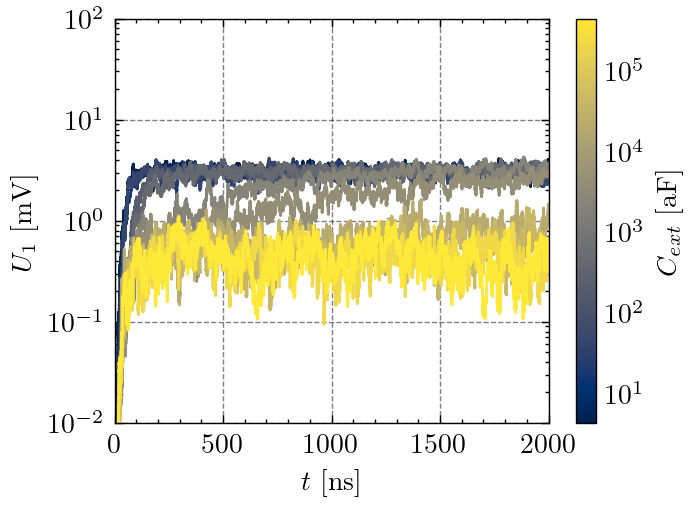

In [3]:
fig     = plt.figure(dpi=200)
ax1     = fig.add_subplot()
norm    = LogNorm(vmin=min(radius_to_capacitance(np.array(cap_vals))), vmax=max(radius_to_capacitance(np.array(cap_vals))))

for i, (key, df) in enumerate(data_cap.items()):

    y   = df['Current']*1000
    y_e = df['Error']*1000

    ax1.plot(t_vals, y, color=cm(norm(radius_to_capacitance(key))))
    # ax1.fill_between(t_vals, y+y_e, y-y_e, alpha=0.2, color='black')

ax1.set_yscale('log')
ax1.set_ylim(1e-2,1e2)
ax1.set_xlim(0,2000)
ax1.set_ylabel('$U_1$ [mV]')
ax1.set_xlabel('$t$ [ns]')

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1)
cbar.set_label("$C_{ext}$ [aF]")

# fig.savefig("../plots/dc_input/output_response.svg", transparent=True)

In [8]:
params      = []
params_st   = []
taus        = []
taus_st     = []

for i, (key, df) in enumerate(data_cap.items()):

    y   = df['Current']*1000
    p,c = curve_fit(exp_saturation, t_vals, y, p0=[key, U_0*100], bounds=[(0,U_0*100-0.1),(np.inf,U_0*100+0.1)])
    params.append(p)
    taus.append(p[0])

cap_vals_t  = np.array(cap_vals).copy()
cap_vals_t  = np.round(radius_to_capacitance(np.array(cap_vals)))
cap_log     = np.log(cap_vals_t[3:])
tau_log     = np.log(taus[3:])
B, log_A    = np.polyfit(cap_log, tau_log, 1)
A2,_        = curve_fit(linear_func, cap_vals_t[3:], taus[3:])
A           = np.exp(log_A)

In [9]:
taus

[np.float64(30.986544847598715),
 np.float64(39.976608199368066),
 np.float64(35.319448797660414),
 np.float64(65.9807964929831),
 np.float64(86.28753613082354),
 np.float64(268.06627518824587),
 np.float64(512.4968089128223),
 np.float64(2470.7620803983405),
 np.float64(5504.0422750522),
 np.float64(25139.411164275687),
 np.float64(33832.835591177914)]

(10.0, 1000000.0)

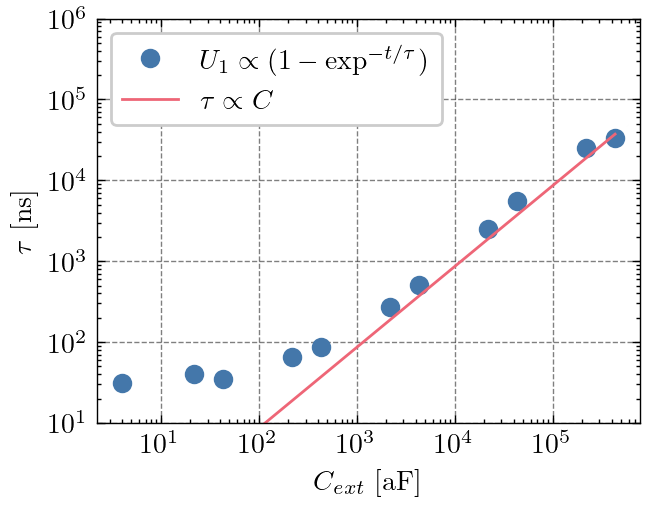

In [12]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(cap_vals_t, taus, 'o', label='$U_1 \propto (1-\exp^{-t/\\tau})$')
# ax.plot(cap_vals_t, 1.7 * cap_vals_t**1, label=f'$\\tau \propto C$')
ax.plot(cap_vals_t, A2 * cap_vals_t, label=f'$\\tau \propto C$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper left')
ax.set_ylabel('$\\tau$ [ns]')
ax.set_xlabel('$C_{ext}$ [aF]')
ax.set_ylim(1e1,1e6)

# fig.savefig("../plots/dc_input/time_scale_vs_cap.svg", transparent=True)

Text(0.5, 0, '$C_{ext}$ [aF]')

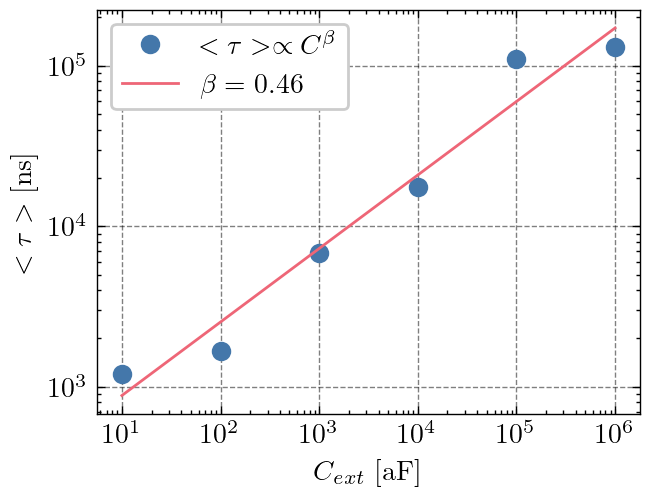

In [13]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(cap_vals_t, streched_moments(taus, betas), 'o', label='$<\\tau> \propto C^{\\beta}$')
ax.plot(cap_vals_t, A * cap_vals_t**B, label=f'$\\beta = {np.round(B,2)}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_ylabel('$<\\tau>$ [ns]')
ax.set_xlabel('$C_{ext}$ [aF]')

# fig.savefig("../plots/dc_input/output_time_scale_vs_cap.svg", transparent=True)
# fig.savefig("../plots/dc_input/output_time_scale_vs_cap.pdf", transparent=False)

In [ ]:
1/(2*np.pi)

In [83]:
A * 5e3 ** B

np.float64(4109.845276695424)

In [82]:
50000*1e-10*1e9

5000.0

In [89]:
1e6/(2*np.pi*4000)

39.78873577297384

In [97]:
1e3/(2*np.pi*20)

7.957747154594767

## Two Step Input

In [41]:
N_voltages      = 200000
steps_between_s = [0,400,800,1600,2000,4000,5000,10000,20000,40000]
steps_per_step  = 40000
time_step       = 1e-9
cap             = 5e3
U_0             = 0.1
t_vals          = np.arange(N_voltages-1)*time_step*1e6
# folder          = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/two_step_input/"
folder          = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/dc_two_step_input/"
data_two        = {steps : pd.read_csv(f"{folder}Nx=9_Ny=9_Nz=1_Ne=8_{steps}.csv") for steps in steps_between_s}

[ 0.59337746 17.07230653]
[ 0.50047496 17.06951707]


(0.0, 10.0)

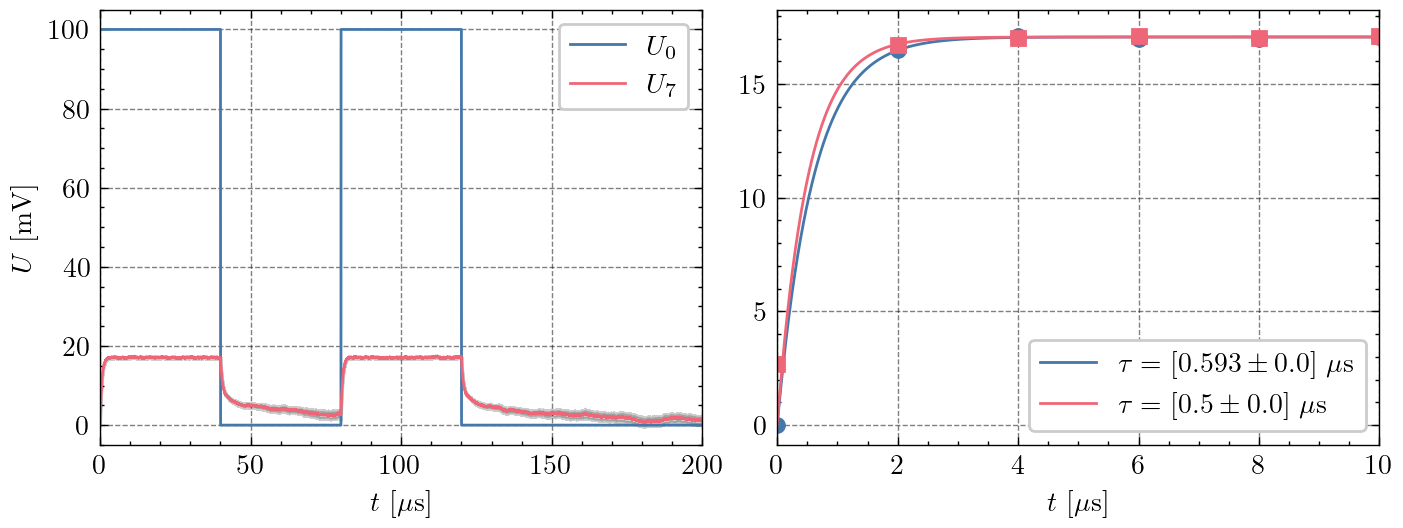

In [44]:
steps_between   = 40000
df              = data_two[steps_between].copy()
fuc             = exp_saturation

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
x   = df['E0'].values*1000
y   = df['Current'].values*1000
y_e = df['Error'].values*1000
y1  = y[:steps_per_step].copy()
y2  = y[steps_per_step+steps_between:2*steps_per_step+steps_between].copy()
# y1  -= y1[0]
# y2  -= y2[0]

ax.plot(t_vals, x, label='$U_0$')
ax.plot(t_vals, y, label='$U_7$')
ax.fill_between(t_vals, y+y_e, y-y_e, color='black', alpha=0.2)
ax.set_ylabel('$U$ [mV]')
ax.set_xlabel('$t$ [$\mu$s]')
ax.set_xlim(0,np.round(np.max(t_vals)))
ax.set_ylim(-5,105)
ax.legend()

ax  = fig.add_subplot(1,2,2)
p,c = curve_fit(fuc, t_vals[:len(y1)], y1, p0=[2,100])
print(p)
p1  = ax.plot(t_vals[:len(y1)],y1, 'o', markevery=2000, ms=5)
ax.plot(t_vals[:len(y1)],fuc(t_vals[:len(y1)],*p), color=p1[0].get_color(), label=f'$\\tau = [{np.round(p[0],3)} \pm {np.round(np.sqrt(c[0,0]),3)}]$ $\mu$s')

p,c = curve_fit(fuc, t_vals[:len(y2)],y2, p0=[2,50])#, bounds=[(0,0,0),(200,np.inf,1)])
print(p)
p2  = ax.plot(t_vals[:len(y2)],y2, 's', markevery=2000, ms=5)
ax.plot(t_vals[:len(y2)],fuc(t_vals[:len(y2)],*p), color=p2[0].get_color(), label=f'$\\tau = [{np.round(p[0],3)} \pm {np.round(np.sqrt(c[0,0]),3)}]$ $\mu$s')
ax.set_xlabel('$t$ [$\mu$s]')
ax.legend(loc='lower right')
# ax.set_xscale('log')
ax.set_xlim(0,10)

# fig.savefig(f"../plots/two_step_inputs/output_response_two_input_cap_{steps_between}.svg", transparent=True)
# fig.savefig(f"../plots/two_step_inputs/output_response_two_input_cap_{steps_between}.pdf", transparent=False)

## Increasing Steps

In [130]:
steps_per_step  = 40000
cap             = 5e3
folder          = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/increasing_steps/"
df              = pd.read_csv(f"{folder}Nx=10_Ny=1_Nz=1_Ne=2_{cap}.csv") 
N_voltages      = len(df)
time_step       = 1e-10
t_vals          = np.arange(N_voltages)*1e-10*1e6

[22.65823247 58.07212674]
[ 3.27628609 17.8294665 ]
[ 7.41421575 43.06513887]
[ 2.98640029 23.38515884]
[ 6.25804016 45.95597669]
[4.97020421 1.42034047]
[ 26.6192968  -37.45821997]
[  4.15274332 -29.64337648]
[  2.49407201 -17.62077896]
[  4.37642488 -37.39508781]


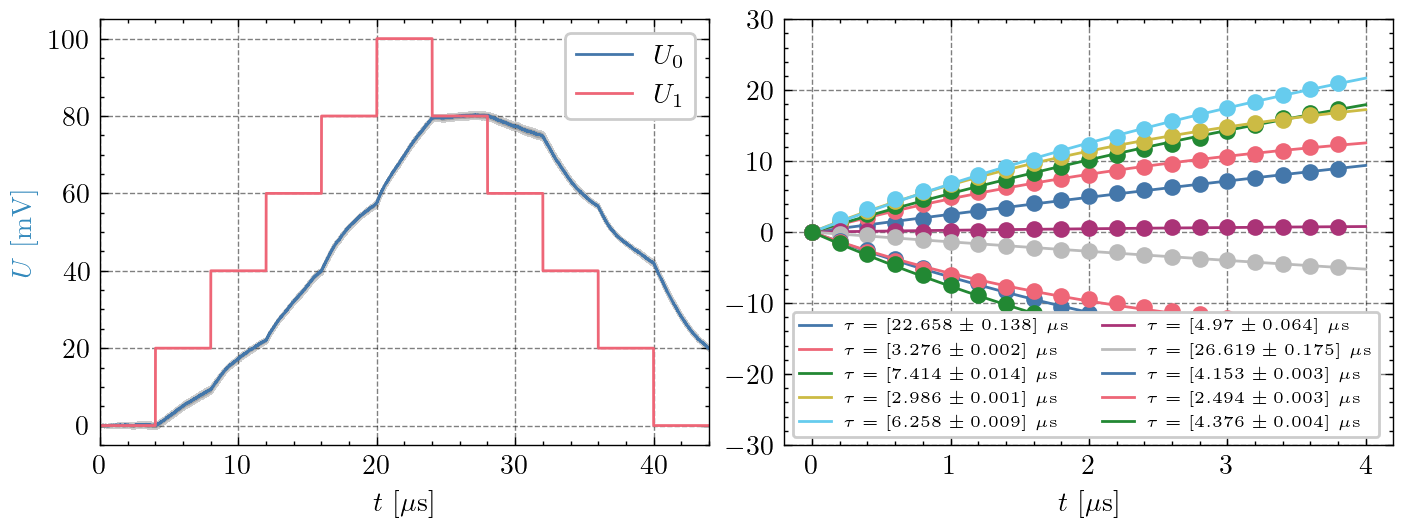

In [131]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
x   = df['E0'].values*1000
y   = df['Current'].values*1000
y_e = df['Error'].values*1000

ax.plot(t_vals, y, label='$U_0$')
ax.fill_between(t_vals, y+y_e, y-y_e, color='black', alpha=0.2)
ax.plot(t_vals, x, label='$U_1$')
ax.set_ylabel('$U$ [mV]', color=nanonets_utils.blue_color)
ax.set_xlabel('$t$ [$\mu$s]')
ax.set_xlim(0,np.round(np.max(t_vals)))
ax.set_ylim(-5,105)
ax.legend()

ax  = fig.add_subplot(1,2,2)
for i in range(1,11):
    y1  =   y[i*steps_per_step:(i+1)*steps_per_step].copy()
    y1  -=  y1[0]
    p,c = curve_fit(exp_saturation, t_vals[:len(y1)], y1)
    print(p)
    p1  = ax.plot(t_vals[:len(y1)], y1, 'o', markevery=2000, ms=5)
    ax.plot(t_vals[:len(y1)], exp_saturation(t_vals[:len(y1)], *p), color=p1[0].get_color(),
            label=f'$\\tau = [{np.round(p[0],3)} \pm {np.round(np.sqrt(c[0,0]),3)}]$ $\mu$s')
ax.set_xlabel('$t$ [$\mu$s]')
ax.legend(fontsize='xx-small', ncol=2)
ax.set_ylim(-30,30)

fig.savefig(f"../plots/increasing_steps.svg", transparent=True)
fig.savefig(f"../plots/increasing_steps.pdf", transparent=False)

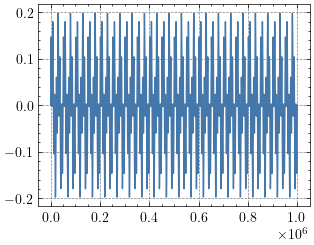

In [106]:
N_voltages  = 1000000
time_step   = 1e-9
U_0         = 0.1
time_steps  = np.arange(N_voltages)*time_step
f0          = 40e3
f1          = 140e3
U_i         = U_0*np.sin(2*np.pi*f0*time_steps) + U_0*np.sin(2*np.pi*f1*time_steps)
plt.plot(U_i)

In [68]:
y1              = y[:steps_per_step]
y2              = y[steps_per_step+steps_between:2*steps_per_step+steps_between]

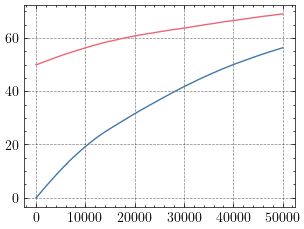

In [69]:
plt.plot(y1)
plt.plot(y2)

In [27]:
t_at_68 = []
U_th    = U_0*0.1 #U_0*0.63

for key, df in data_cap.items():

    t_at_68.append(t_vals[np.where(df['Current'].values > U_th)[0][0]])

t_at_68

IndexError: index 0 is out of bounds for axis 0 with size 0

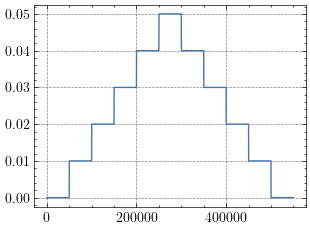

In [66]:
steps_per_step  = 50000
U_step          = 0.01
U_i1            = U_step*np.repeat(np.arange(6),steps_per_step)
U_i2            = U_step*np.repeat(np.arange(4,-1,-1),steps_per_step)
U_i             = np.hstack((U_i1,U_i2))
plt.plot(U_i)

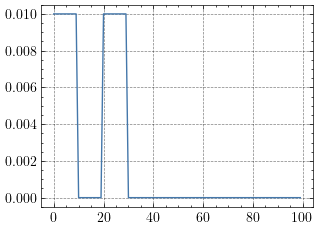

In [24]:
steps_per_step  = 10
steps_between   = 10
start           = 0
U_step          = 0.01
N_voltages      = 100
U_i                                                                             = np.zeros(N_voltages)
U_i[start:steps_per_step]                                                       = U_step
U_i[start+steps_per_step+steps_between:start+2*steps_per_step+steps_between]    = U_step

plt.plot(U_i)

Text(0.5, 0, '$t$ [ns]')

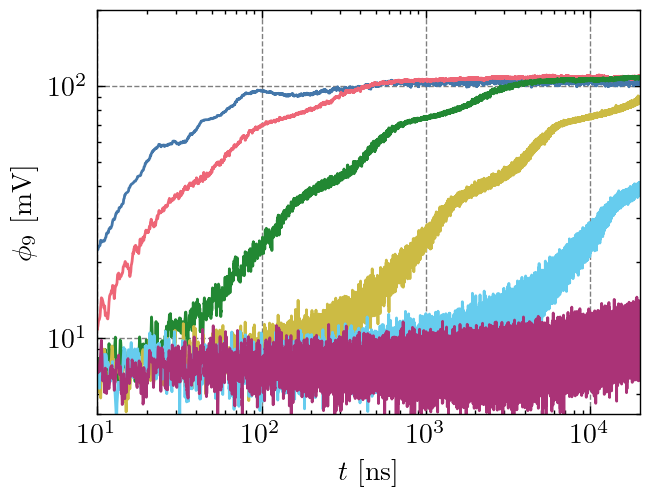

In [162]:
fig = plt.figure(dpi=200)
ax2 = fig.add_subplot()

for i, (key, df) in enumerate(data_cap.items()):

    p   = pot_cap[key]['9']*1000
    ax2.plot(t_vals, p)

ax2.set_yscale('log')
ax2.set_ylim(5e0,2e2)
ax2.set_xscale('log')
ax2.set_xlim(10,np.max(t_vals))
ax2.set_ylabel('$\phi_9$ [mV]')
ax2.set_xlabel('$t$ [ns]')

In [109]:
t_at_68 = []

for key, df in data_cap.items():

    t_at_68.append(t_vals[np.where(df['Current'].values > 0.068)[0][0]])

IndexError: index 0 is out of bounds for axis 0 with size 0

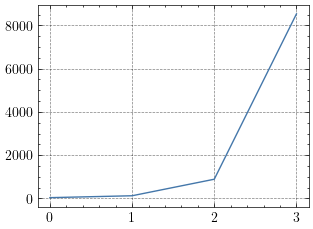

In [111]:
plt.plot(t_at_68)

In [151]:
def exp_saturation(x, tau, a0):
    return a0*(1 - np.exp(-x/tau))
def stretched_exp_saturation(x, tau, beta, a0):
    return a0*(1 - np.exp(-(x/tau)**beta))
def power_law_saturation(x, tau, beta, a0):
    return a0*(1 - (x/tau)**(-beta))
def double_exp_saturation(x, tau1, tau2, a1, a2):
    return a1*(1 - np.exp(-x/tau1)) + a2*(1 - np.exp(-x/tau2))
def hyperbolic_saturation(x, tau, a0):
    return a0*(1 - 1/(1+x/tau))
def log_saturation(x, tau, a0):
    return a0*(1 - 1/np.log(1+x/tau))
def modified_exp_saturation(x, tau1, tau2, a1, a2):
    return a1*(1-np.exp(-x/tau1)) + a2*np.exp(-x/tau2)
def logistic_function(x, tau, a0, x0):
    return a0 / (1 + np.exp(-(x-x0)/tau))
def generalized_logistic_function(x, tau, a0, x0, nu1, nu2):
    return a0 / ((1 + nu1*np.exp(-(x-x0)/tau))**(1/nu2))
def exp_power_law_saturation(x, tau1, tau2, alpha, beta, a0):
    return a0*(1 - np.exp(-(x/tau1)**alpha))*(1 + x/tau2)**(-beta)

/tmp/ipykernel_29226/3010679329.py:20: RuntimeWarning: invalid value encountered in power
  return a0*(1 - np.exp(-(x/tau1)**alpha))*(1 + x/tau2)**(-beta)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.

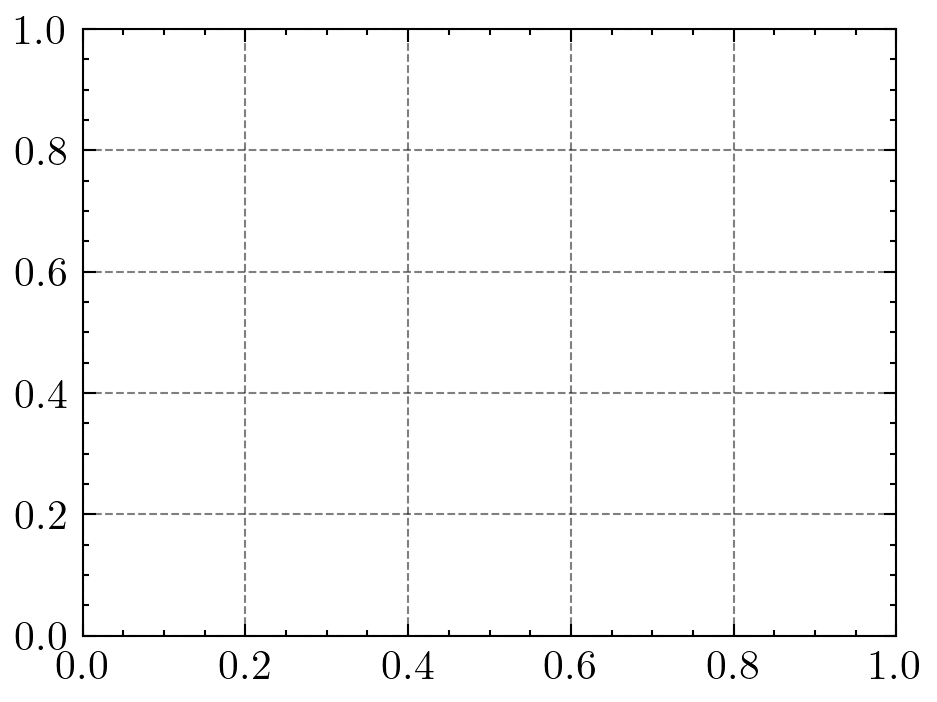

In [153]:
params  = []
stds    = []
func    = exp_power_law_saturation
p0      = [100, 1, 100]

fig = plt.figure(dpi=300)
ax  = fig.add_subplot()

for i, (key, df) in enumerate(data_cap.items()):

    y   = df['Current']*1000
    p,c = curve_fit(func, t_vals, y, maxfev=2000, p0=[key, 10, 1, 1, 1])
    pl  = ax.plot(t_vals, y, '.', ms=1)
    ax.plot(t_vals, func(t_vals, *p), c=pl[0].get_color())

    params.append(p)
    stds.append(np.sqrt(c[0,0]))

    print(p)

# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-5,1e3)
ax.set_xlim(0,50)
ax.set_ylabel('$U_1$ [mV]')
ax.set_xlabel('$t$ [ns]')